In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
# import tensorflow as tf
# import tensorflow_datasets as tfds
jax.config.update('jax_platform_name', 'gpu')

In [3]:
jax.__version__

'0.4.12'

In [4]:
import jax
import jax.numpy as jnp


## Jax test
jax.config.update('jax_platform_name', 'gpu')


def test_vmap(m):
    return jnp.sin(m)


jax.vmap(test_vmap)(jnp.ones(4))


## Numba test
from numba import jit, cuda
import numpy as np
# to measure exec time
from timeit import default_timer as timer   
  
# normal function to run on cpu
def func(a):                                
    for i in range(10000000):
        a[i]+= 1      
  
# function optimized to run on gpu 
@jit(target_backend='cuda')                         
def func2(a):
    for i in range(10000000):
        a[i]+= 1
if __name__=="__main__":
    n = 10000000                            
    a = np.ones(n, dtype = np.float64)
      
    start = timer()
    func(a)
    print("without GPU:", timer()-start)    
      
    start = timer()
    func2(a)
    print("with GPU:", timer()-start)


/tmp/ipykernel_354559/2230675028.py:28: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(target_backend='cuda')


KeyboardInterrupt: 

: 

In [ ]:
class MyLinear1(hk.Module):

  def __init__(self, output_size, name=None):
    super().__init__(name=name)
    self.output_size = output_size

  def __call__(self, x):
    j, k = x.shape[-1], self.output_size
    w_init = hk.initializers.TruncatedNormal(1. / np.sqrt(j))
    w = hk.get_parameter("w", shape=[j, k], dtype=x.dtype, init=w_init)
    b = hk.get_parameter("b", shape=[k], dtype=x.dtype, init=jnp.ones)
    return jnp.dot(x, w) + b

In [ ]:
def _forward_fn_linear1(x):
  module = MyLinear1(output_size=2)
  return module(x)

forward_linear1 = hk.transform(_forward_fn_linear1)

In [ ]:
dummy_x = jnp.array([[1., 2., 3.]])
rng_key = jax.random.PRNGKey(42)

params = forward_linear1.init(rng=rng_key, x=dummy_x)
params

{'my_linear1': {'w': Array([[-0.30350366,  0.5123803 ],
         [ 0.08009139, -0.3163005 ],
         [ 0.60566676,  0.5820702 ]], dtype=float32),
  'b': Array([1., 1.], dtype=float32)}}

In [ ]:
sample_x = jnp.array([[1., 2., 3.]])
sample_x_2 = jnp.array([[4., 5., 6.], [7., 8., 9.]])

output_1 = forward_linear1.apply(params=params, x=sample_x, rng=rng_key)
# Outputs are identical for given inputs since the forward inference is non-stochastic.
output_2 = forward_linear1.apply(params=params, x=sample_x, rng=rng_key)

output_3 = forward_linear1.apply(params=params, x=sample_x_2, rng=rng_key)

print(f'Output 1 : {output_1}')
print(f'Output 2 (same as output 1): {output_2}')
print(f'Output 3 : {output_3}')

Output 1 : [[2.6736794 2.62599  ]]
Output 2 (same as output 1): [[2.6736794 2.62599  ]]
Output 3 : [[3.819336  4.9589844]
 [4.965576  7.2924805]]


In [ ]:
forward_without_rng = hk.without_apply_rng(hk.transform(_forward_fn_linear1))
params = forward_without_rng.init(rng=rng_key, x=sample_x)
output = forward_without_rng.apply(x=sample_x, params=params)
print(f'Output without random key in forward pass \n {output}')
print(f'Output w random key in forward pass \n {output_1}')

Output without random key in forward pass 
 [[2.6736794 2.62599  ]]
Output w random key in forward pass 
 [[2.6736794 2.62599  ]]


In [ ]:
params

{'my_linear1': {'w': Array([[-0.30350366,  0.5123803 ],
         [ 0.08009139, -0.3163005 ],
         [ 0.60566676,  0.5820702 ]], dtype=float32),
  'b': Array([1., 1.], dtype=float32)}}

In [ ]:
mutated_params = jax.tree_util.tree_map(lambda x: x+1., params)
print(f'Mutated params \n : {mutated_params}')
mutated_output = forward_without_rng.apply(x=sample_x, params=mutated_params)
print(f'Output with mutated params \n {mutated_output}')

Mutated params 
 : {'my_linear1': {'b': Array([2., 2.], dtype=float32), 'w': Array([[0.69649637, 1.5123804 ],
       [1.0800914 , 0.6836995 ],
       [1.6056668 , 1.5820701 ]], dtype=float32)}}
Output with mutated params 
 [[9.673679 9.62599 ]]


In [ ]:
def stateful_f(x):
  counter = hk.get_state("counter", shape=[], dtype=jnp.int32, init=jnp.ones)
  multiplier = hk.get_parameter('multiplier', shape=[1,], dtype=x.dtype, init=jnp.ones)
  hk.set_state("counter", counter + 1)
  output = x + multiplier * counter
  return output

stateful_forward = hk.without_apply_rng(hk.transform_with_state(stateful_f))
sample_x = jnp.array([[5., ]])
params, state = stateful_forward.init(x=sample_x, rng=rng_key)
print(f'Initial params:\n{params}\nInitial state:\n{state}')
print('##########')
for i in range(3):
  output, state = stateful_forward.apply(params, state, x=sample_x)
  print(f'After {i+1} iterations:\nOutput: {output}\nState: {state}')
  print('##########')

Initial params:
{'~': {'multiplier': Array([1.], dtype=float32)}}
Initial state:
{'~': {'counter': Array(1, dtype=int32)}}
##########
After 1 iterations:
Output: [[6.]]
State: {'~': {'counter': Array(2, dtype=int32)}}
##########
After 2 iterations:
Output: [[7.]]
State: {'~': {'counter': Array(3, dtype=int32)}}
##########
After 3 iterations:
Output: [[8.]]
State: {'~': {'counter': Array(4, dtype=int32)}}
##########


In [ ]:

def forward(x):
  mlp = hk.nets.MLP([300, 100, 10])
  return mlp(x)

forward = hk.transform(forward)

rng = hk.PRNGSequence(jax.random.PRNGKey(42))
x = jnp.ones([8, 28 * 28])

pool = list('ACTG')
r = np.random.choice(pool, 100)
# x = jnp.zeros([8, 28 * 28])
params = forward.init(next(rng), x)
logits = forward.apply(params, next(rng), x)

In [ ]:

def f(x):
  return hk.nets.MLP([300, 100, 10])(x)

f = hk.transform(f)
x = jnp.ones([8, 28 * 28])

print(hk.experimental.tabulate(f)(x))

+-------------------------+------------------------------------------+-----------------+------------+------------+---------------+---------------+
| Module                  | Config                                   | Module params   | Input      | Output     |   Param count |   Param bytes |
+=========================+==========================================+=================+============+============+===============+===============+
| mlp (MLP)               | MLP(output_sizes=[300, 100, 10])         |                 | f32[8,784] | f32[8,10]  |       266,610 |       1.07 MB |
+-------------------------+------------------------------------------+-----------------+------------+------------+---------------+---------------+
| mlp/~/linear_0 (Linear) | Linear(output_size=300, name='linear_0') | w: f32[784,300] | f32[8,784] | f32[8,300] |       235,500 |     942.00 KB |
|  └ mlp (MLP)            |                                          | b: f32[300]     |            |            |    

In [ ]:
for method_invocation in hk.experimental.eval_summary(f)(x):
  print(method_invocation)

MethodInvocation(module_details=ModuleDetails(module=MLP(output_sizes=[300, 100, 10]), method_name='__call__', params={'mlp/~/linear_0/b': f32[300], 'mlp/~/linear_0/w': f32[784,300], 'mlp/~/linear_1/b': f32[100], 'mlp/~/linear_1/w': f32[300,100], 'mlp/~/linear_2/b': f32[10], 'mlp/~/linear_2/w': f32[100,10]}, state={}), args_spec=(f32[8,784],), kwargs_spec={}, output_spec=f32[8,10], context=MethodContext(module=MLP(output_sizes=[300, 100, 10]), method_name='__call__', orig_method=functools.partial(<function MLP.__call__ at 0x7f09e0b3b3a0>, MLP(output_sizes=[300, 100, 10]))), call_stack=(ModuleDetails(module=MLP(output_sizes=[300, 100, 10]), method_name='__call__', params={'mlp/~/linear_0/b': f32[300], 'mlp/~/linear_0/w': f32[784,300], 'mlp/~/linear_1/b': f32[100], 'mlp/~/linear_1/w': f32[300,100], 'mlp/~/linear_2/b': f32[10], 'mlp/~/linear_2/w': f32[100,10]}, state={}),))
MethodInvocation(module_details=ModuleDetails(module=Linear(output_size=300, name='linear_0'), method_name='__call__

Visualise

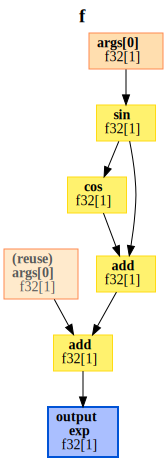

In [ ]:
def f(a):
  b = jnp.sin(a)
  c = jnp.cos(b)
  d = b + c
  e = a + d
  e = jnp.exp(e)
  return e

x = jnp.ones([1])
dot = hk.experimental.to_dot(f)(x)

import graphviz
graphviz.Source(dot)

In [ ]:
import os
import sys

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)
    
from src.models.nucleotide_transformer import build_nucleotide_transformer_fn

build_nucleotide_transformer_fn(model_config=1)

<function src.models.nucleotide_transformer.build_nucleotide_transformer_fn.<locals>.nucleotide_transformer_fn(tokens: jax.Array, attention_mask: Optional[jax.Array] = None) -> Dict[str, jax.Array]>

MLP tute

In [36]:
import haiku as hk
import jax.numpy as jnp
import jax
import numpy as np

def softmax_cross_entropy(logits, labels):
  one_hot = jax.nn.one_hot(labels, logits.shape[-1])
  return -jnp.sum(jax.nn.log_softmax(logits) * one_hot, axis=-1)


def mlp(images):
  mlp = hk.Sequential([
      hk.Linear(300), jax.nn.relu,
      hk.Linear(100), jax.nn.relu,
      hk.Linear(10),
  ])
  return mlp(images)


mlp_t = hk.transform(mlp)
mlp_t = hk.without_apply_rng(mlp_t)


def loss_fn(params, labels):
  logits = mlp_t.apply(params, images)
  return jnp.mean(softmax_cross_entropy(logits, labels))


n = 1000
w, h = 15, 5
tn = 100
images_all = np.random.rand(n, w, h)
# labels_all = np.floor(images_all * 10)
labels_all = np.ones((n, 1, 1))
images_test = np.random.rand(tn, w, h)
labels_test = np.floor(images_test * 10)


rng = jax.random.PRNGKey(42)
dummy_images, dummy_labels = images_all[0], labels_all[0]
params = mlp_t.init(rng, dummy_images)

def update_rule(param, update):
  return param - 0.01 * update

grads_all = np.zeros((n, 3))
for i, (images, labels) in enumerate(zip(images_all, labels_all)):
  grads = jax.grad(loss_fn)(params, labels)
  grads_all[i, 0] = jnp.absolute(grads['linear']['w']).sum()
  grads_all[i, 1] = jnp.absolute(grads['linear_1']['w']).sum()
  grads_all[i, 2] = jnp.absolute(grads['linear_2']['w']).sum()
  params = jax.tree_util.tree_map(update_rule, params, grads)
  params = jax.tree_util.tree_map(update_rule, params, grads)
  

/home/wadh6511/Kode/env_evo/lib/python3.9/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [17]:
logits = mlp_t.apply(params, images_test[0])
logits

Array([[-0.44850487,  9.274708  , -1.6857686 , -0.9921229 , -0.7001314 ,
        -1.1474675 , -1.0855478 , -0.8224974 , -1.3092616 , -1.0816361 ],
       [-0.29113716,  7.3523006 , -1.2658844 , -0.7116047 , -0.54260105,
        -0.9841253 , -0.87839675, -0.6435888 , -1.0939714 , -0.728914  ],
       [-0.49973667, 11.181992  , -1.996651  , -1.15138   , -0.7602691 ,
        -1.3858075 , -1.4259282 , -0.86549556, -1.6628782 , -1.358954  ],
       [-0.49003738, 10.892954  , -2.0172853 , -1.1810578 , -0.7072219 ,
        -1.4302205 , -1.149041  , -1.0107725 , -1.4727114 , -1.1542073 ],
       [-0.42251742,  9.352699  , -1.7321544 , -0.8715066 , -0.6710065 ,
        -1.1938742 , -0.9773188 , -0.7978685 , -1.2992688 , -0.99081016],
       [-0.3402748 ,  8.910042  , -1.6365385 , -0.86331636, -0.63381743,
        -1.1037927 , -1.0628982 , -0.74866843, -1.394672  , -0.98409224],
       [-0.4262358 ,  9.850201  , -1.7338064 , -1.0260893 , -0.718949  ,
        -1.1807095 , -1.2460243 , -0.90589446

In [37]:

print(hk.experimental.tabulate(mlp_t.apply)(dummy_images))

+----------------------------+--------------------------------------------------------------------------------+-----------------+-------------+-------------+---------------+---------------+
| Module                     | Config                                                                         | Module params   | Input       | Output      |   Param count |   Param bytes |
+============================+================================================================================+=================+=============+=============+===============+===============+
| sequential (Sequential)    | Sequential(                                                                    |                 | f32[15,5]   | f32[15,10]  |        32,910 |     131.64 KB |
|                            |     layers=[Linear(output_size=300),                                           |                 |             |             |               |               |
|                            |             <jax._s

<Axes: >

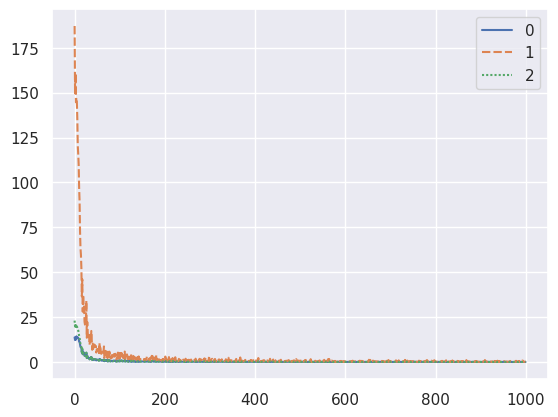

In [16]:
sns.lineplot(grads_all)

Training subset of params https://dm-haiku.readthedocs.io/en/latest/notebooks/non_trainable.html

In [65]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np

num_classes = 10

def f(x):
  return hk.nets.MLP([300, 100, 100, num_classes])(x)

f = hk.transform(f)

def test(params, num_classes=num_classes):
  x = np.arange(num_classes).reshape([num_classes, 1]).astype(np.float32)
  y = jnp.argmax(f.apply(params, None, x), axis=-1)
  for x, y in zip(x, y):
    print(x, "->", y)

rng = jax.random.PRNGKey(42)
x = np.zeros([num_classes, 1])
params = f.init(rng, x)

print("before training")
test(params)

before training
[0.] -> 0
[1.] -> 4
[2.] -> 4
[3.] -> 4
[4.] -> 4
[5.] -> 4
[6.] -> 4
[7.] -> 4
[8.] -> 4
[9.] -> 4


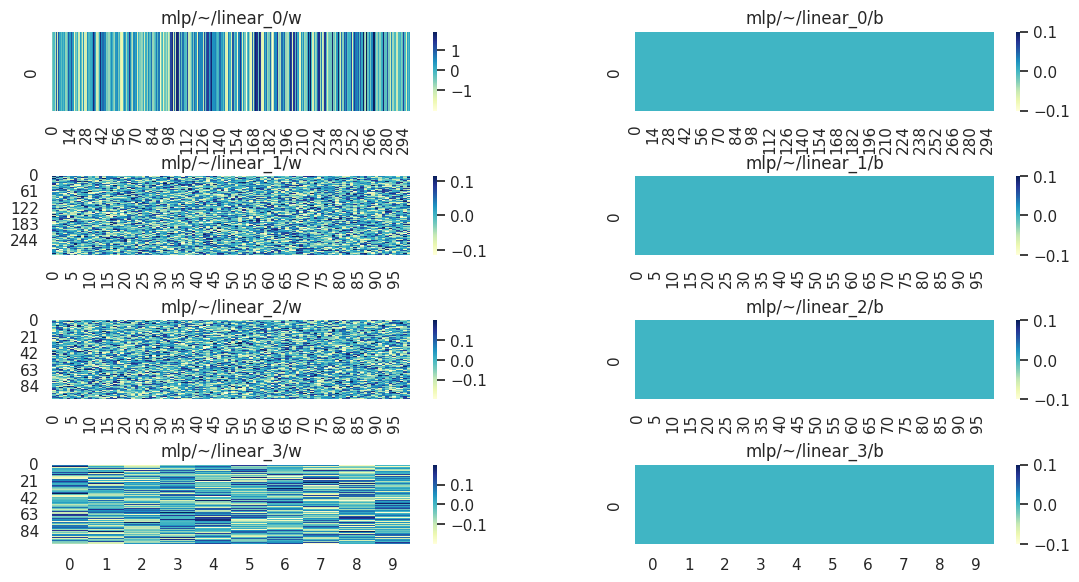

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

def plot_params(params):
  fig, axs = plt.subplots(ncols=2, nrows=4)
  fig.tight_layout()
  fig.set_figwidth(12)
  fig.set_figheight(6)
  for row, module in enumerate(sorted(params)):
    ax = axs[row][0]
    sns.heatmap(params[module]["w"], cmap="YlGnBu", ax=ax)
    ax.title.set_text(f"{module}/w")

    ax = axs[row][1]
    b = np.expand_dims(params[module]["b"], axis=0)
    sns.heatmap(b, cmap="YlGnBu", ax=ax)
    ax.title.set_text(f"{module}/b")

plot_params(params)

In [68]:
def dataset(*, batch_size, num_records):
  for _ in range(num_records):
    y = np.arange(num_classes)
    y = np.random.permutation(y)[:batch_size]
    x = y.reshape([batch_size, 1]).astype(np.float32)
    yield x, y

for x, y in dataset(batch_size=4, num_records=5):
  print("x :=", x.tolist(), "y :=", y)

x := [[5.0], [8.0], [0.0], [7.0]] y := [5 8 0 7]
x := [[5.0], [2.0], [0.0], [1.0]] y := [5 2 0 1]
x := [[8.0], [6.0], [4.0], [1.0]] y := [8 6 4 1]
x := [[4.0], [2.0], [8.0], [5.0]] y := [4 2 8 5]
x := [[0.0], [1.0], [9.0], [2.0]] y := [0 1 9 2]


In [71]:
# Partition our params into trainable and non trainable explicitly.
trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda m, n, p: (m != "mlp/~/linear_1") & (m != "mlp/~/linear_2"), params)

print("trainable:", list(trainable_params))
print("non_trainable:", list(non_trainable_params))

trainable: ['mlp/~/linear_0', 'mlp/~/linear_3']
non_trainable: ['mlp/~/linear_1', 'mlp/~/linear_2']


In [75]:
def loss_fn(trainable_params, non_trainable_params, images, labels):
  # NOTE: We need to combine trainable and non trainable before calling apply.
  params = hk.data_structures.merge(trainable_params, non_trainable_params)

  # NOTE: From here on this is a standard softmax cross entropy loss.
  logits = f.apply(params, None, images)
  labels = jax.nn.one_hot(labels, logits.shape[-1])
  return -jnp.sum(labels * jax.nn.log_softmax(logits)) / labels.shape[0]

def sgd_step(params, grads, *, lr):
  return jax.tree_util.tree_map(lambda p, g: p - g * lr, params, grads)

def train_step(trainable_params, non_trainable_params, x, y):
  # NOTE: We will only compute gradients wrt `trainable_params`.
  trainable_params_grads = jax.grad(loss_fn)(trainable_params,
                                             non_trainable_params, x, y)

  # NOTE: We are only updating `trainable_params`.
  trainable_params = sgd_step(trainable_params, trainable_params_grads, lr=0.1)
  return trainable_params

train_step = jax.jit(train_step)

for x, y in dataset(batch_size=num_classes, num_records=20000):
  # NOTE: In our training loop only our trainable parameters are updated.
  trainable_params = train_step(trainable_params, non_trainable_params, x, y)

In [76]:
# Merge params again for inference.
params = hk.data_structures.merge(trainable_params, non_trainable_params)

print("after training")
test(params)
print("More after training")
test(params, num_classes=num_classes+10)

after training
[0.] -> 0
[1.] -> 1
[2.] -> 2
[3.] -> 3
[4.] -> 4
[5.] -> 5
[6.] -> 6
[7.] -> 7
[8.] -> 8
[9.] -> 9
More after training
[0.] -> 0
[1.] -> 1
[2.] -> 2
[3.] -> 3
[4.] -> 4
[5.] -> 5
[6.] -> 6
[7.] -> 7
[8.] -> 8
[9.] -> 9
[10.] -> 9
[11.] -> 9
[12.] -> 9
[13.] -> 9
[14.] -> 9
[15.] -> 9
[16.] -> 9
[17.] -> 9
[18.] -> 9
[19.] -> 9


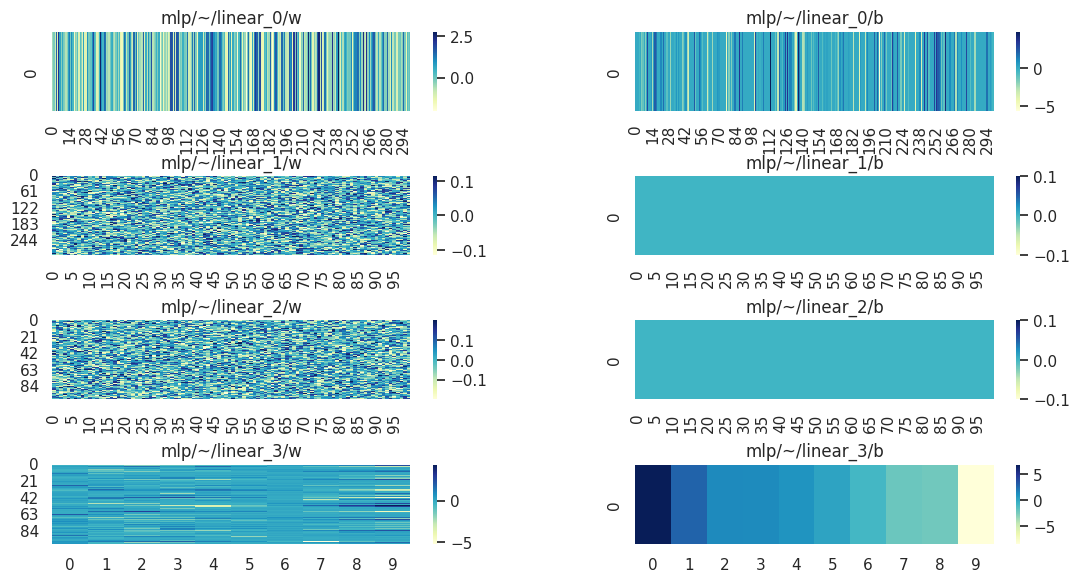

In [77]:
plot_params(params)